# Model Evaluation: ResNet18 Mushroom Classifier

In this notebook, the best checkpoint of the fine-tuned `ResNet18` model from `03_model_training.ipynb` is evaluated.

The model was trained to identify bitter boletes (Tylopilus felleus) and distinguish them from other boletes that are edible.
The training metric `Recall` was used to train the model to prioritize identifying many positive labels, as in this case it is important to identify all mushrooms that could render a meal inedible.

- **Label 0**: Non-bitter boletes (Boletus edulis, Imleria badia)  
- **Label 1**: Bitter bolete (Tylopilus felleus)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from torch.utils.data import DataLoader

from utils.image_dataset import ImageDataset, get_transforms
from utils.model_training import get_resnet_model

## Setup and Configuration

In [2]:
CONFIG = {
    "model_path": "checkpoints/ResNet18_epoch_15.pth",
    "test_csv": "data/testing_split.csv",
    "data_dir": "data/images",
    "batch_size": 128,
    "num_workers": 0,
    "image_size": (299, 299),
    "num_classes": 2,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ["Edible Bolete", "Bitter Bolete"]

# Load model
model = get_resnet_model("Resnet18")
model.fc = nn.Linear(model.fc.in_features, CONFIG["num_classes"])
model = model.to(device)

checkpoint = torch.load(CONFIG["model_path"], map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model loaded successfully.")

Model loaded successfully.


## Model Evaluation

In [3]:
# Cross-Validation Evaluation on Test Dataset
from sklearn.model_selection import StratifiedKFold

test_data = pd.read_csv(CONFIG["test_csv"])
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
precision_scores, recall_scores, f1_scores, accuracy_scores = [], [], [], []

for fold, (_, test_idx) in enumerate(skf.split(test_data, test_data["label_id"]), 1):
    fold_data = test_data.iloc[test_idx]
    fold_dataset = ImageDataset(fold_data, transform=get_transforms(transform_type="testing"))
    fold_loader = DataLoader(
        fold_dataset,
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        num_workers=CONFIG["num_workers"],
    )
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for images, labels in fold_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    report = classification_report(fold_labels, fold_preds, target_names=class_names, output_dict=True)
    precision = report["macro avg"]["precision"] # type: ignore
    recall = report["macro avg"]["recall"] # type: ignore
    f1 = report["macro avg"]["f1-score"] # type: ignore
    accuracy = report["accuracy"] # type: ignore

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

    print(f"Fold {fold} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | Acc: {accuracy:.3f}")

print(f"Average Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
print(f"Average Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
print(f"Average F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}")

Fold 1 | Precision: 0.885 | Recall: 0.875 | F1: 0.863 | Acc: 0.864
Fold 2 | Precision: 0.752 | Recall: 0.752 | F1: 0.727 | Acc: 0.727
Fold 3 | Precision: 0.818 | Recall: 0.829 | F1: 0.817 | Acc: 0.818
Fold 4 | Precision: 0.846 | Recall: 0.846 | F1: 0.818 | Acc: 0.818
Fold 5 | Precision: 0.752 | Recall: 0.752 | F1: 0.727 | Acc: 0.727
Fold 6 | Precision: 0.745 | Recall: 0.736 | F1: 0.714 | Acc: 0.714
Fold 7 | Precision: 0.909 | Recall: 0.917 | F1: 0.905 | Acc: 0.905
Fold 8 | Precision: 0.875 | Recall: 0.875 | F1: 0.857 | Acc: 0.857
Fold 9 | Precision: 0.903 | Recall: 0.903 | F1: 0.903 | Acc: 0.905
Fold 10 | Precision: 0.846 | Recall: 0.833 | F1: 0.809 | Acc: 0.810
Average Precision: 0.833 ± 0.060
Average Recall: 0.832 ± 0.062
Average F1-score: 0.814 ± 0.067
Average Accuracy: 0.815 ± 0.068


## Confusion Matrix

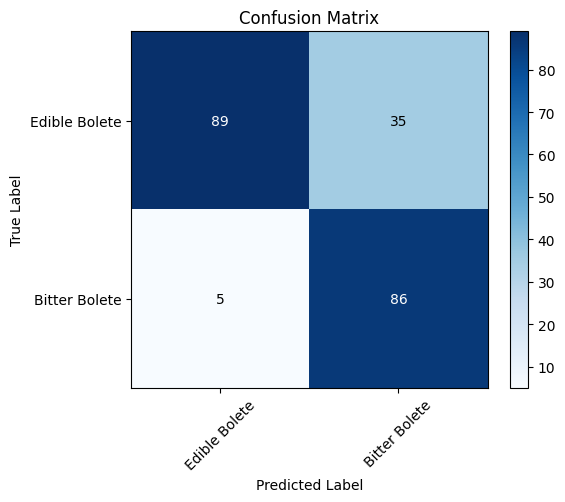

In [4]:
# Prepare the full test dataset for confusion matrix and AUROC
test_dataset = ImageDataset(test_data, transform=get_transforms(transform_type="testing"))
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=CONFIG["num_workers"],
)

# Get predictions and probabilities for the entire test set
true_labels, predictions, probabilities = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)
probabilities = np.array(probabilities)

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
        )

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## AUROC Plot

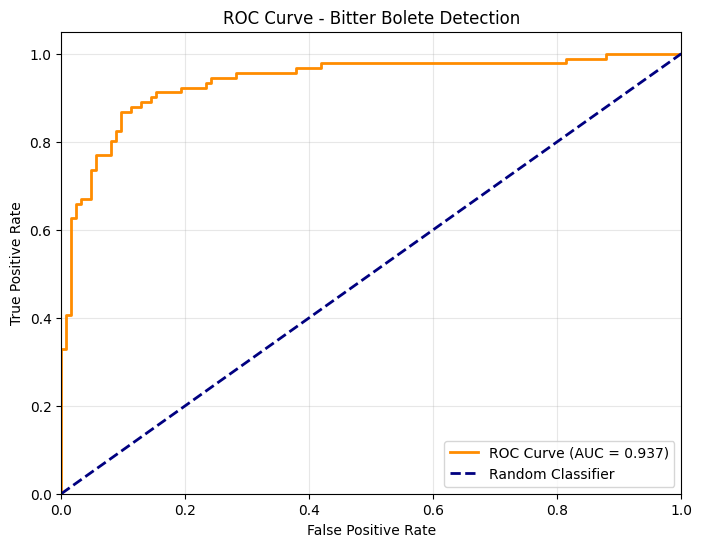

In [ ]:
# Calculate ROC curve and AUC
positive_class_probs = probabilities[:, 1]  # type: ignore
fpr, tpr, thresholds = roc_curve(true_labels, positive_class_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Bitter Bolete Detection")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()